## 多层感知机实现

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

### Relu 函数

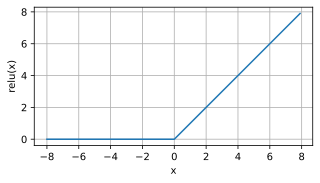

In [3]:
x = torch.arange(-8.0,8.0,0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(),y.detach(), 'x', 'relu(x)', figsize=(5,2.5))

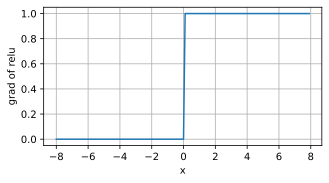

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5,2.5))

### sigmoid 函数：

$sigmoid(x) = \frac{1}{1+e^{-x}}$

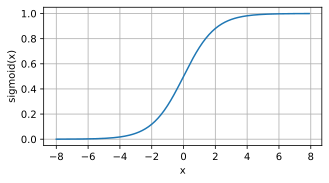

In [5]:
y = torch.sigmoid(x)
d2l.plot(x.detach(),y.detach(), 'x', 'sigmoid(x)', figsize=(5,2.5))

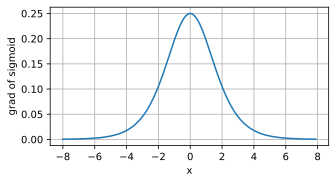

In [6]:
x.grad.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5,2.5))

### tanh 函数
$tanh(x) = \frac{1-e^{-2x}}{1+e^{-2x}} $

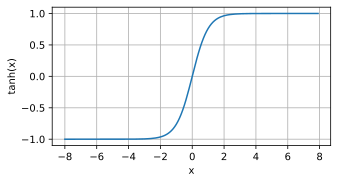

In [7]:
y = torch.tanh(x)
d2l.plot(x.detach(),y.detach(), 'x', 'tanh(x)', figsize=(5,2.5))

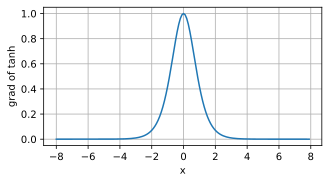

In [8]:
x.grad.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5,2.5))

### MLP从零开始实现

In [9]:
from torch import nn

In [10]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [11]:
num_inputs,num_outputs,num_hiddens = 784,10,256
W1 = nn.Parameter(torch.randn(num_inputs,num_hiddens,requires_grad=True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1,b1,W2,b2]

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X,a)


In [12]:
def net(X):
    X = X.reshape((-1,num_inputs))
    H = relu(torch.matmul(X,W1)+b1)
    return torch.matmul(H,W2)+b2

In [13]:
loss = nn.CrossEntropyLoss()

In [14]:
import ch3

In [15]:
# 重新加载 ch3 以应用最新修改（无需重启内核）
import importlib
importlib.reload(ch3)

<module 'ch3' from 'e:\\learning\\Learning_python_deeplearning\\learning-python-deeplearning\\ch3.py'>

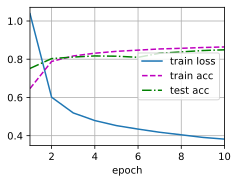

In [16]:
num_epochs,lr = 10,0.1
updater = torch.optim.SGD(params, lr=lr)
ch3.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

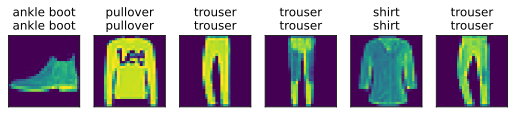

In [17]:
ch3.predict_ch3(net, test_iter)

### MLP简洁实现

In [18]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    nn.ReLU(),
    nn.Linear(256,10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

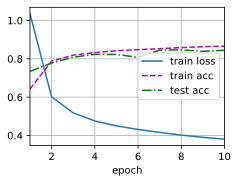

In [19]:
batch_size,lr,num_epochs = 256,0.1,10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
ch3.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 权重衰减

使用正则化参数$\lambda$，构造$L(W,b)+\frac{1}{2}\left \| W \right \|^2 $

使用高维线性回归来演示权重衰减

In [20]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import ch3

In [21]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [22]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [23]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [24]:
def train(lambd):
    w, b = init_params()
    net = lambda X: d2l.linreg(X, w, b)
    loss = d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.353079795837402


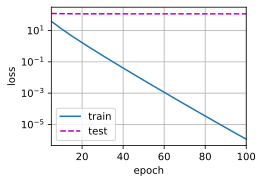

In [25]:
train(lambd=0)  # 没有正则化

w的L2范数是： 0.4024234712123871


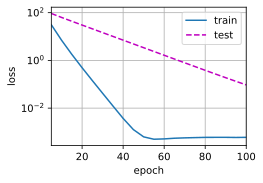

In [26]:
train(lambd=3)  # 有正则化

### 简洁实现

In [27]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    loss = nn.MSELoss()
    lr, num_epochs = 0.003, 100
    trainer = torch.optim.SGD([{"params": net[0].weight, "weight_decay": wd}, {"params": net[0].bias}], lr=lr)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(net[0].weight).item())

w的L2范数是： 0.14053964614868164


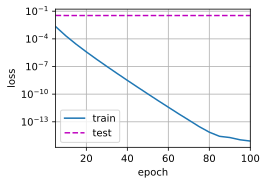

In [28]:
train_concise(wd=0)  # 没有正则化

w的L2范数是： 0.04116765037178993


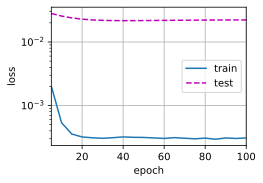

In [29]:
train_concise(wd=3)  # 有正则化

### 暂退法

随机丢弃一部分神经元，然后防止只依靠一部分神经元起作用

In [30]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, drop_prob):
    assert 0 <= drop_prob <= 1
    if drop_prob == 1:
        return torch.zeros_like(X)
    if drop_prob == 0:
        return X
    mask = (torch.rand(X.shape) > drop_prob).float()
    return mask * X / (1.0 - drop_prob)

In [31]:
X = torch.arange(16, dtype=torch.float).reshape((2, 8))
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 0.2))
print(dropout_layer(X, 1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  8., 10., 12.,  0.],
        [ 0.,  0., 20., 22., 24.,  0., 28.,  0.]])
tensor([[ 0.0000,  0.0000,  2.5000,  3.7500,  5.0000,  6.2500,  7.5000,  8.7500],
        [10.0000, 11.2500, 12.5000, 13.7500, 15.0000,  0.0000, 17.5000,  0.0000]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [32]:
num_inputs,num_outputs,num_hiddens1,num_hiddens2 = 784,10,256,256
drop_prob1,drop_prob2 = 0.2,0.5
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.linear1 = nn.Linear(num_inputs, num_hiddens1)
        self.linear2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.linear3 = nn.Linear(num_hiddens2, num_outputs)
        self.is_training = is_training
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.linear1(X.reshape((-1, self.num_inputs))))
        if self.is_training:  # 只在训练模型时使用丢弃法
            H1 = dropout_layer(H1, drop_prob1)
        H2 = self.relu(self.linear2(H1))
        if self.is_training:
            H2 = dropout_layer(H2, drop_prob2)
        return self.linear3(H2)

net = Net(num_inputs,num_outputs,num_hiddens1,num_hiddens2)

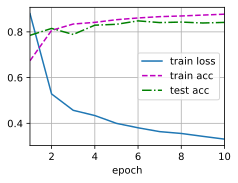

In [33]:
num_epochs, lr ,batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(),lr = lr)
ch3.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

In [34]:
# 简洁实现
net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),nn.Dropout(drop_prob1),nn.Linear(256,256),nn.ReLU(),nn.Dropout(drop_prob2),nn.Linear(256,10))
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std = 0.01)
net.apply(init_weight);

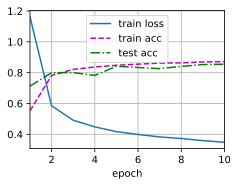

In [35]:
trainer = torch.optim.SGD(net.parameters(),lr = lr)
ch3.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

In [36]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

In [37]:
def download(name, cache_dir=os.path.join('.', 'data')):
    """下载 DATA_HUB 中登记的文件, 返回本地文件路径"""
    assert name in DATA_HUB, f"{name} 不在 DATA_HUB 中，可用键: {list(DATA_HUB.keys())}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])

    # 如果已存在文件且哈希正确，直接返回
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1 << 20)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
        else:
            print("哈希不匹配，重新下载...")

    print(f"正在从 {url} 下载到 {fname}")
    r = requests.get(url, stream=True, timeout=30)
    r.raise_for_status()
    with open(fname, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1 << 20):
            if chunk:
                f.write(chunk)
    return fname

In [38]:
def download_extract(name, folder=None): #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir
def download_all(): #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)


In [39]:
import numpy as np
import pandas as pd
print(DATA_HUB)

{}


In [40]:
DATA_HUB['kaggle_house_train'] = ( #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = ( #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
print(DATA_HUB)

{'kaggle_house_train': ('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv', '585e9cc93e70b39160e7921475f9bcd7d31219ce'), 'kaggle_house_test': ('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv', 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')}


In [41]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [42]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [43]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [44]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))